In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


In [82]:
import kagglehub
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
os.listdir(path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [83]:
df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [84]:
print(f'{df.shape}')
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


- There are differnt types int64, float65 and objects
- Object need to be converted into numbers
- columns like customer id can be dropped
- churn colum also should not be used for traning

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- Check for missing values in the columns
- The sum of all null values per column is zero

In [86]:
# check for missing value in this case there is no missing values in dataset
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


- Exploring the churn values
- Currently vas majority of values are not churn 76% and only 26.5% churn
- Data is imblananced

In [87]:
print(f"\nChurn Distribution:\n{df['Churn'].value_counts()}")
print(f"\nChurn Percentage:\n{df['Churn'].value_counts(normalize=True) * 100}")


Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


- Total Charges was an object, unlike monthly charges etc, which were numbers
- Need to convert to numeric but conversion might lead to null values for values that couldn't convert
- Out of the 7043 values, only 11 became NaN
- Options to handle missing values: median, mean or simply removing
- These rows belong to customers with 0 tenure months (they just signed up) and don't have any charges
- These rows make up only 0.156% of the total data removing them would have small impact
- Imputing these values with mean, median etc. might lead to distortion by inflating the total charges for new customers so removing is the best option

In [88]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f'{df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()].shape}')
print(f'{df.shape}')
df[df['TotalCharges'].isna()]


(11, 21)
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [89]:
# This drops the NaN form the total charges
df.dropna(subset=['TotalCharges'], inplace=True)
df.shape

(7032, 21)

- Dropping customerID as it is a unique value per customer
- It dosen't have any info that would help in prediction

In [90]:
df.drop('customerID', axis=1, inplace=True)
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


- For ML these columns need to be converted to binary values
- So most columns with objects have Yes-No values can be converted to 0: No and 1: Yes
- Gender can be conveted to 0: Male and 1: Female
- Colums like OnlineSecurity, OnnlineBackup, StreamingTv, TechSupport, MultipleLines etc have some unique No values these can be simply converted to No

In [91]:
def unique_col_values(df):
    for column in df:
      if df[column].dtypes == 'object':
        print(f'{column}: {df[column].unique()}')
unique_col_values(df)


gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


- Converted first values like No Internet Service in column to just No
- No Internet service indicates that customer does not have service at all which means that the question of internet subscription wouldn't apply to them at all
- So this category was merted with No since they both indicate that customer did not subscribe to their service

In [92]:
from pandas.core.algorithms import unique
df1 = df.copy()

cols_no_internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df1[cols_no_internet_services] = df1[cols_no_internet_services].replace('No internet service', 'No')

cols_no_phone_services = ['MultipleLines']
df1[cols_no_phone_services] = df1[cols_no_phone_services].replace('No phone service', 'No')

unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


- Now values were converted to binary variables 1 for Yes and 0 for no
- Also converted male to 0 and female to 1
- Simplifies features for ML models

In [93]:
yes_no_columns = [
    'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'Churn'
]

for col in yes_no_columns:
    df1[col] = df1[col].replace({'No': 0, 'Yes': 1})


# Convert male and female to binary 1 and 0 also
df1['gender'] = df1['gender'].replace({'Male': 0, 'Female': 1})


def col_values(df):
    for column in df:
        print(f'{column}: {df[column].unique()}')

col_values(df1)


gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


Several columns in this dataset (e.g., `InternetService`, `Contract`, `PaymentMethod`) are categorial and are not simple Yes/No fields.  
KNN and SVM require numeric input, we need to convert these categories into numbers in a way that doesn’t introduce a fake ordering.

EX if we encoded:
- `Month-to-Month = 0`
- `One year = 1`
- `Two year = 2`
the model might incorrectly treat these values as having a order and distance (e.g., “Two year” > “One year” > “Month-to-Month”), which is not what we want.

One-hot encoding is used to avoid this with `pd.get_dummies`. One-hot encoding creates a separate column for each category and uses 0/1 indicators. For instance, a `Contract` value of *"One year"* becomes:
- `Contract_Month-to-month = 0`  
- `Contract_One year = 1`  
- `Contract_Two year = 0`

This allows the model to learn a separate weight for each contract type without assuming any ordering between them.

In [94]:
df2 = pd.get_dummies(df1, columns=['InternetService', 'Contract', 'PaymentMethod'])
df2 = df2.astype(int)
col_values(df2)

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
PaperlessBilling: [1 0]
MonthlyCharges: [ 29  56  53  42  70  99  89 104  49  18 100 103 105 113  20 106  55  90
  39  19  59  30  64  96  95  66  45  69  74  97  79  76  84  80 108  24
 107  54  94  75  78 111 110  25  50  62  33  82  21  98  57  91  31  85
  88  23  58  35  44  71 101  68  86  73  81  51 109 112 102  46  93  65
  48  40  83 115 114  41  61  60  67  72  87  92 116  43  28  63  47  34
  26  52  77  36  38 118 117  22  37]
TotalCharges: [  29 1889  108 ... 1990 7362 6844]
Churn: [0 1]
InternetService_DSL: [1 0]
Int

### Train/Validation/Test Split

- X: All input variables used to predict churn.  
- Y: The `Churn` column we want the model to learn and predict.

ML models take x features and target y to train on x and predict y

### First Split (Train vs. Temp)

We first split the dataset into:
- 70% Train
- 30% Temp (this will later be split into validation and test sets)

- `x_train` and `y_train` are what the model learns from.
- `x_temp` and `y_temp` is a placeholder so we can later create a validation and test set.
- `stratify=y` ensures the churn distribution (Yes/No) remains consistent across splits.  
  - This is important because the dataset is imbalanced (more No Churn than Churn cases).  
  - Without stratification, the smaller sets might contain too few churn cases, leading to biased evaluation.
- `random_state=42` ensures reproducibility every run produces the same split.

### Second Split (Validation vs. Test)

The temporary 30% set is then split evenly:
- 15% Validation
- 15% Test

- Validation set:
 For the model development and to tune hyperpramaters to avoid overfitting
- Test set:
  Used at the end to evaluate final model performance. Provides an unbiased estimate of how the model will perform on new, unseen data.

In [95]:
x = df2.drop('Churn', axis=1)
y = df2['Churn']

x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

### Feature Scaling

- These columns have numeric values that are not simply 0 or 1.
- These values exist on very different scales (for example, `TotalCharges` can be very large, while `tenure` is relatively small).
Scaling is important because:
- Algorithms like **KNN**, **SVM**, **Logistic Regression**, and **Neural Networks** are sensitive to feature magnitude.
- No scaling then the features with large values like `TotalCharges` will dominate smaller features like `tenure`

#### Data Leakage

- `fit_transform()` only on the training set
  - computes the scaling statistics (min, max)  
  - scales the training data  
- `transform()` on the validation and test sets  
  - uses the same scaling parameters learned from the training data  

This ensures no info from the validation or test sets leaks into the training process to keep the model eval unbiased

#### Scaling
Scaling should be done after splitting the dataset.

If scaling is done before the split:
- The scaler would compute statistics using the entire dataset, including the test set.
- This leaks info from the test set into the training process.
- The models preformance might look better than it is because it could basically "cheat" since it sees the test


In [96]:
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()

x_train_scaled_numeric = scaler.fit_transform(x_train[cols_to_scale])
x_val_scaled_numeric = scaler.transform(x_val[cols_to_scale])
x_test_scaled_numeric = scaler.transform(x_test[cols_to_scale])

# Make copies of X to avoid changing original
x_train_scaled = x_train.copy()
x_val_scaled = x_val.copy()
x_test_scaled = x_test.copy()

# Replace numeric columns with scaled values
x_train_scaled[cols_to_scale] = x_train_scaled_numeric
x_val_scaled[cols_to_scale] = x_val_scaled_numeric
x_test_scaled[cols_to_scale] = x_test_scaled_numeric


In [97]:
col_values(x_train_scaled)

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [0 1]
Dependents: [1 0]
tenure: [-0.83346894 -0.50805797 -1.24023266  0.06141124  1.60711337  0.63088044
 -1.19955629  1.40373151  0.38682221  1.15967328  0.14276398 -1.0368508
 -0.71143982 -0.79279257  1.20034965 -0.91482168  0.75290956  0.5495277
 -0.99617443  1.48508425 -1.28090903  0.34614584 -0.67076345 -0.34535248
  1.1189969  -0.10129425  0.02073487 -0.95549806  1.44440788  0.22411673
  1.56643699 -0.58941071 -0.30467611 -0.54873434  0.99696779  0.87493867
  0.10208761  0.8342623   1.03764416  0.46817496 -0.63008708  0.2647931
 -1.11820354 -0.46738159 -0.0199415   0.50885133 -1.15887991  0.67155682
  0.71223319  1.07832053 -0.26399974  1.36305514 -0.87414531 -0.7521162
 -0.18264699  0.95629142  0.42749858  0.79358593  0.30546947 -0.38602885
  1.52576062 -0.06061788  0.59020407 -0.42670522  0.91561505 -1.07752717
  1.32237876  0.18344035  1.28170239 -0.22332336 -0.14197062  1.24102602]
PhoneService: [1 0]
MultipleLines: [1 0]
OnlineSecu

# K-NN Analysis

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
import time

K is the number of nearest neighbors the KNN algorithm considers when classifying.

#### K-value:
- Smaller K value (1–3):
  - Sensitive to noise.
  - Can lead to overfitting and the model may memorize the training data.
  - Results in high training accuracy but poor performance on new/test data.

- Larger k value (25–30):
  - Smooths out noise by considering many neighbors but can lead to underfitting (losing details)

- Odd K values tests:
  - To avoid ties when performing majority voting.
  - Ex: if K = 4, predictions could tie (2 votes for class A, 2 votes for class B). Using odd K avoids this.

### Tracking Model Performance

`knn_results` holds the evaluation results to analyze how different K values affect performance.
- **k:** Value of K tested.
- **training_accuracy:** Accuracy on the training set.  
  - Overfitting? then High training accuracy + lower validation accuracy
- **validation_accuracy:** Accuracy on unseen validation data.
- **precision:** Of all customers predicted as churn, how many actually churned.
- **recall:** Of all actual churners, how many the model correctly identified.
- **f1 score:** Balance of precision and recall good for imbalanced datasets like this dataset.
- **roc_auc:** Area under the ROC curve measures how well the model distinguishes churn vs. non-churn.  
  - Good imbalanced datasets like Telco.
- **training_time:** Time required to train/predict for a given K.
  - Larger K then slower prediction

In [99]:
k_values = range(1, 31, 2)

knn_results = {
    'k': [],
    'training_accuracy': [],
    'validation_accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': [],
    'training_time': []
}

### KNN Results

#### Key Findings
- Training accuracy decreased as K increased. Small K values overfit the Telco data, especially due to many one-hot encoded categorical features.
- Validation accuracy peaked at K = 25, meaning this is the best balance between underfitting and overfitting.
- Precision, recall, and F1 score improved as K increased, meaning the model became more consistent at identifying churners. This was a slight but steady increase
- ROC–AUC steadily increased, showing better separation between churn and non-churn customers.
- Training time remained very fast, with only small variations where there was peaks in increase.

### Analysis of why this occured
- The Telco dataset has high-dimensional, sparse features from one-hot encoding.  
  - With small K, KNN becomes overly sensitive to rare combinations of features this lead to noisy predictions and causes the model to overfit.
  - Larger K averages out this nois which leads to improvements in the F1 and ROC–AUC.

- Remember this dataset is imbalanced with fewer churners.  
  - Small K would mean it follows the majority (non-churn) neighbors.  
  - Larger K reduces this effect, helping the model capture more churners leading to higher recall and F1.

### Conclusion
KNN performance consistently improved as K increased.  
Small K values overfit, while mid-range K values (15–31) produced smoother, more reliable decision boundaries.

At K = 25 it gave the best validation accuracy and the best churn-detection metrics (F1 and ROC–AUC ~0.84).  

In [100]:
for k in k_values:

    start_time = time.time()

    # Using euclidean distance to test
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(x_train_scaled, y_train)
    training_time = time.time() - start_time

    # prediction on traning data, valadation data, proabability prediction
    y_train_pred = knn.predict(x_train_scaled)
    y_val_pred = knn.predict(x_val_scaled)

    # gives probababilites for both classes and selects the postive class
    # This is for metrics like ROC-auc, recall etc which depend on postive class
    y_val_prob = knn.predict_proba(x_val_scaled)[:, 1]

    # Append each metric to the dictonary per k to analyze
    knn_results['k'].append(k)
    knn_results['training_accuracy'].append(accuracy_score(y_train, y_train_pred))
    knn_results['validation_accuracy'].append(accuracy_score(y_val, y_val_pred))
    knn_results['precision'].append(precision_score(y_val, y_val_pred))
    knn_results['recall'].append(recall_score(y_val, y_val_pred))
    knn_results['f1_score'].append(f1_score(y_val, y_val_pred))
    knn_results['roc_auc'].append(roc_auc_score(y_val, y_val_prob))
    knn_results['training_time'].append(training_time)

knn_results_df = pd.DataFrame(knn_results)
print(knn_results_df.to_string(index=False))

 k  training_accuracy  validation_accuracy  precision   recall  f1_score  roc_auc  training_time
 1           0.989842             0.731754   0.496795 0.551601  0.522766 0.674380       0.004857
 3           0.862251             0.758294   0.547445 0.533808  0.540541 0.761345       0.002961
 5           0.838480             0.770616   0.573585 0.540925  0.556777 0.791151       0.002911
 7           0.832792             0.777251   0.587786 0.548043  0.567219 0.797654       0.002321
 9           0.830557             0.775355   0.586614 0.530249  0.557009 0.810434       0.002351
11           0.823649             0.778199   0.588679 0.555160  0.571429 0.817862       0.002310
13           0.816335             0.794313   0.623077 0.576512  0.598891 0.823122       0.002437
15           0.816944             0.785782   0.605364 0.562278  0.583026 0.828795       0.002429
17           0.811865             0.789573   0.613027 0.569395  0.590406 0.830706       0.002335
19           0.812475         

### Training vs. Validation Accuracy

This graph is used to get the elbow point where validation accuracy peaks and the gap between training and validation accuracy is smallest. A large gap would mean its overfitting.

#### Training Accuracy
- Starts high and gradually decreases as K increases.
- **Small K** means it memorizes training data (overfitting)
- **Larger K** means smoother decision boundaries, it is better at generalization but slightly lower training accuracy.
- We expect that with more neighbors it should weaken the influence of single data points.

#### Validation Accuracy
- Starts lower, then steadily improves as K increases, and eventually levels it levels out.
- **Small K** mean there is high variance and poor generalization on Telco customers.
- **Moderate K** then here the noise is reduced in this high-dimensional and accuracy improves
- **Very large K** it may oversmooth the decision boundary so need to be careful

#### Best Region
Found again that at K = 25, the model reaches its a good balance:
- Training accuracy ≈ 0.807  
- Validation accuracy ≈ 0.809
- The gap is small meaning its no overfitting or underfitting.

### Conclusion

Telco churn data has many one-hot encoded features so its high-dimensional and might have lots of noise.
Small K values overfit these features, while moderate K values (15–31) smooth out the noise and it does better at generalizing  to new customers.

Graph shows lot:
- Small K (3–7) has very high traning accuracy (~86%) but low valadation accuracy  
- Medium K (~25) has both almost connect


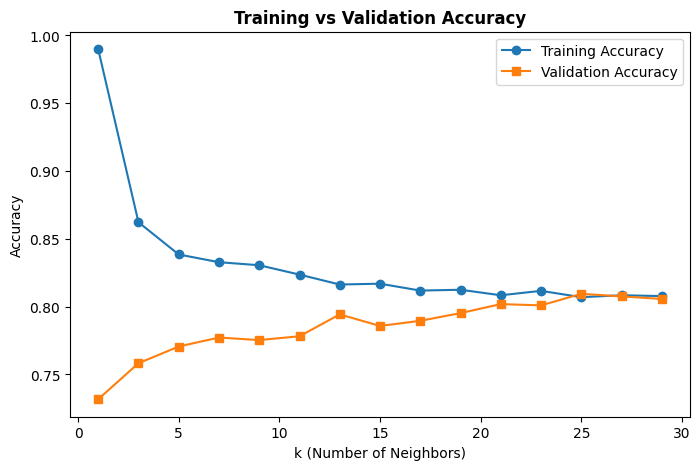

In [101]:
plt.figure(figsize=(8, 5))
plt.plot(knn_results_df['k'], knn_results_df['training_accuracy'], marker='o', label='Training Accuracy')
plt.plot(knn_results_df['k'], knn_results_df['validation_accuracy'], marker='s', label='Validation Accuracy')

plt.title('Training vs Validation Accuracy', fontweight='bold')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

### Precision, Recall, and F1 Score

These metrics will help us understand how well the model is at finding churners (the positive class).  
K value should try and balance precision and recall. F1 score is the balance.
### Precision  
- Of all customers predicted to churn, how many actually churned?  
- Precision increases as K increases and peaks at K = 25.  
- Small K is noisy and is  not good at identifying non-churn customers as churn (false positives).  
- Large K value average over more neighbors thisreduces noise so fewer false alarms.  
- Good for this dataset becasue remember customers with short tenure or high charges may look risky but often don't churn.

### Recall  
- Of all actual churners, how many did we correctly identify?
- Recall also increases with K but its alot more gradual.  
- Larger nehibours help the model consistently detect churners which reduces false negatives.
- Good for this dataset becasue its imbalanced churn data. Missing churners would be bad.

### F1 Score  
- F1 score improves with K because its a balance of both precision and recall.  
- Small K overfits on this noisy, high-dimensional one-hot encoded features.  
- Moderate K (around 21–27) smooths noise to make predictions more reliable.  
- Highest F1 values is with moderate, meaning its a good balance between catching churners and avoiding unessary customers.

### Analysis: Larger values of K (21-27)
- High-dimensional dataset due to many categorical features ( like contract type, services, payment method).
- Customer behavior is variable and noisy.  
- With small K it magnifies the rare or noisy feature combinations ( like one unusual customer churns then the model assumes all similar customers churn).  
- Larger K smooths so identifying patterns across broader groups of customers rather than reacting to small edge cases.

### Conclusion
Precision, recall, and F1 all improve steadily as K increases, stabilizing around after K=21 so K=25 good choise.

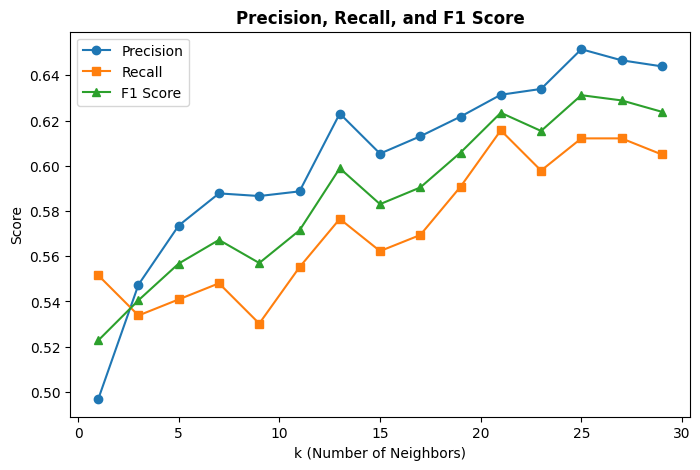

In [102]:
plt.figure(figsize=(8, 5))
plt.plot(knn_results_df['k'], knn_results_df['precision'], marker='o', label='Precision')
plt.plot(knn_results_df['k'], knn_results_df['recall'], marker='s', label='Recall')
plt.plot(knn_results_df['k'], knn_results_df['f1_score'], marker='^', label='F1 Score')

plt.title('Precision, Recall, and F1 Score', fontweight='bold')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Score')

plt.legend()
plt.show()

### ROC–AUC

ROC–AUC measures how well the model ranks churners above non-churners.  
- A higher AUC (closer to 1) means a model that ranks positive cases (churners) higher than negative ones (non-churners).
- A lower AUC (closer to 0.5) means the model is not performing better than random guessing, or it may be worse than random guessing if it’s below 0.5.
- Low K then noisy decision boundary this leads to a poor ranking ability, ROC–AUC is around 0.76  
- Higher K values then its smoother, more generalizable and ROC–AUC rises to around 0.84  
- Large K the curve seems to levels off, then adding more neighbors doesn’t improve ranking much beyond 25–31  

#### 1. High-Dimensional, Mixed Feature Space
- Our dataset has many one-hot encoded features plus numeric variables.  
- Euclidean distance becomes distorted in this high-dimensional space.  
- Small K might react strongly to edge cases like rare customer patterns, lowering ROC–AUC.  
- Larger K reduce this sensitivity so it improves consistency in churn

#### 2. Class Imbalance (Only ~26% churners)
- ROC–AUC is good to look at here because it evaluates ranking, not the raw accuracy.  
- Small K, churners are inconsistently detected leading to poor ranking.  
- Larger K the model averages across more neighbors so thechurners get higher, more stable scores.

### Conclusion
The ROC–AUC vs. K plot shows the classifier improves as K increases, peaking around 0.84 at K = 25  
So the model here becomes better at identifying customers that are most at risk of churning

Mid-range K values provide are the best balance
- Reduce overfitting caused by high-dimensional one-hot features  
- Smooth out noisy behavior patterns in customer usage  
- Improve the model’s ability to rank churn risk consistently  

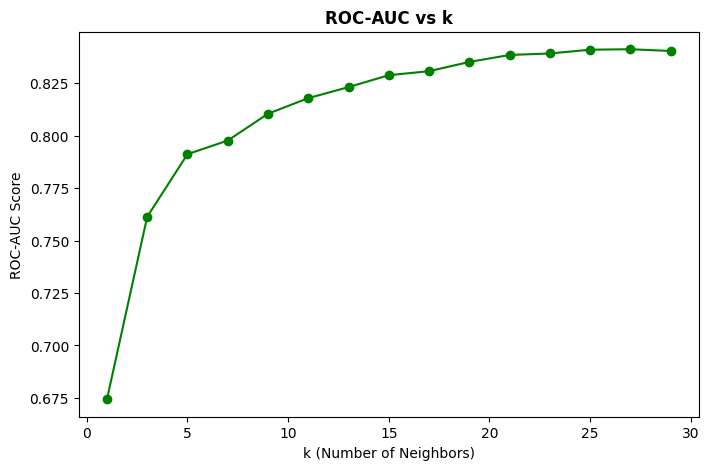

In [103]:
plt.figure(figsize=(8, 5))
plt.plot(knn_results_df['k'], knn_results_df['roc_auc'], marker='o', color='green')

plt.title('ROC-AUC vs k', fontweight='bold')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('ROC-AUC Score')

plt.show()


### Training Time vs. K

Training time for KNN is very small across all K values, with only slight fluctuations.  
Expected because KNN is a lazy learner it does not build a model during training it just stores the dataset and it calcuates during prediction.
- “Training” = saving the scaled feature matrix and labels.  
- Computation (distance calculations) happens when predicting, not during training.

### Conclusion
- Dataset has ~7,000 rows and 20–30 one-hot encoded features.  
- Manageable size, KNN training is effectively instant, making it good to use for:
  - Testing different distance metrics  
  - Using KNN as a baseline model before moving to more complex methods


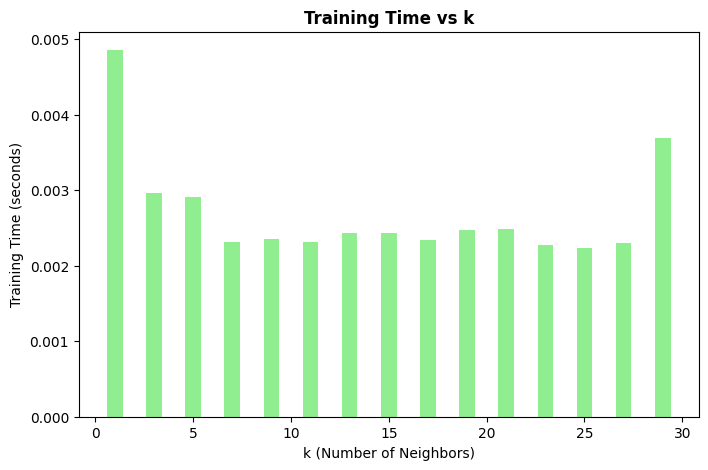

In [104]:
plt.figure(figsize=(8, 5))
plt.bar(knn_results_df['k'], knn_results_df['training_time'], color='lightgreen')

plt.title('Training Time vs k', fontweight='bold')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Training Time (seconds)')

plt.show()

### Comparing Euclidean vs. Manhattan Distance (K = 25)

- Euclidean distance: Straight-line distance, remember this is sensitive to magnitude differences but the features are scaled during pre-processing.  
- Manhattan distance: City-block distance its better in high-dimensional (one-hot encoding).
- If Euclidean wins then the numerical features like `tenure` and `MonthlyCharges` are more meaningful.  
- If Manhattan wins then high-dimensional categorical patterns are meaningful.

### Results
- Euclidean distance performed slightly better on every major metric (accuracy, precision, recall, and F1), while both were similar in ROC-AUC.
- Telco has important numeric features (tenure, monthly charges, total charges).  
  - Euclidean distance might increase differences in these features, helping separate churners.
- Manhattan treats each feature difference equally.  
  - This might be bad for identifying churners and non-churners, especially when numeric differences matter.

### Conclusion

Euclidean distance is the preferred metric for KNN on the Telco Churn dataset.  
- Better accuracy and F1 score  
- More reliable identification of churners  
- Stronger use of numerical behavior patterns (usage, billing, tenure)


In [105]:
# Compare Euclidean vs Manhattan distance
distance_metrics = ['euclidean', 'manhattan']
distance_results = []

for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=25, metric=metric)
    knn.fit(x_train_scaled, y_train)

    y_val_pred = knn.predict(x_val_scaled)
    y_val_proba = knn.predict_proba(x_val_scaled)[:, 1]

    result = {
        'Metric': metric,
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred),
        'F1-Score': f1_score(y_val, y_val_pred),
        'ROC-AUC': roc_auc_score(y_val, y_val_proba)
    }
    distance_results.append(result)

distance_df = pd.DataFrame(distance_results)
print(distance_df.to_string(index=False))

   Metric  Accuracy  Precision   Recall  F1-Score  ROC-AUC
euclidean  0.809479   0.651515 0.612100  0.631193 0.840940
manhattan  0.800000   0.631579 0.597865  0.614260 0.840665


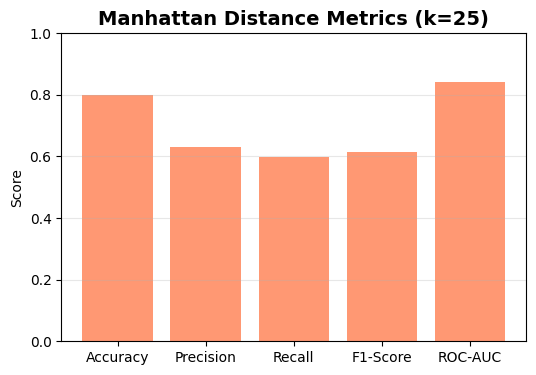

In [106]:
manhattan_row = distance_df[distance_df['Metric'] == 'manhattan']

plt.figure(figsize=(6, 4))
plt.bar(manhattan_row.columns[1:], manhattan_row.iloc[0, 1:], color='coral', alpha=0.8)
plt.title(f'Manhattan Distance Metrics (k=25)', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

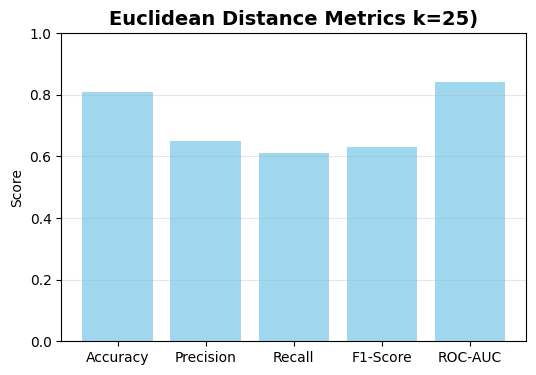

In [107]:
euclidean_row = distance_df[distance_df['Metric'] == 'euclidean']

plt.figure(figsize=(6, 4))
plt.bar(euclidean_row.columns[1:], euclidean_row.iloc[0, 1:], color='skyblue', alpha=0.8)
plt.title(f'Euclidean Distance Metrics k=25)', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()


# SVM Analysis

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

In [109]:
# Test different kernels with default C=1.0
kernels = ['linear', 'rbf', 'poly']
kernel_results = []


In [110]:
for kernel in kernels:
    print(f"Training SVM with {kernel}\n")

    start_time = time.time()
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(x_train_scaled, y_train)
    training_time = time.time() - start_time

    y_val_pred = svm.predict(x_val_scaled)
    y_val_proba = svm.predict_proba(x_val_scaled)[:, 1]

    result = {
        'Kernel': kernel,
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred),
        'F1-Score': f1_score(y_val, y_val_pred),
        'ROC-AUC': roc_auc_score(y_val, y_val_proba),
        'Training_Time': training_time,
        'Support_Vectors': svm.n_support_.sum()
    }
    kernel_results.append(result)

Training SVM with linear

Training SVM with rbf

Training SVM with poly



### SVM Kernel Comparison

- Train SVM models using three kernels linear, rbf, and polynomial with the default hyperparameters. Good baseline for tune.
- The linear and rbf kernels seem to show best results, so they were later tested with GridSearchCV (this process took an extreamly long amout of time).  
- Even after tuning but we found that still the linear SVM achieved the best F1 score than the rbf.

- To note something to consider is that with more extensive preprocessing and hyperparameter tuning, a non-linear RBF SVM might outperform linear (this is what we initally expected). But based on my testing the linear pereformned the best

#### 1. One-Hot Encoding Creates High-Dimensional Sparse Features  
- Internet service, contract type, payment method, etc. become many sparse (0,1) columns.  
- Linear models handle this type of data the best.  
- Non-linear kernels (like RBF) try to form complex boundaries that don’t match the structure of the data and end up splitting on noise

#### 2. Important Features Are Broad, Not Complex  
- With early analysis we found that **tenure, contract type, and charges** are the best features for churn predictors.  
- These variables separate churn vs. non-churn in some what linear manner so a linear boundary works well.  
- RBF might attempt to try and capture small patterns that may not be meaningful overall.

#### 3. Training-Time Considerations  
- Linear SVM converged quickly.  
- RBF required much more time to train and tune on my current hardware which made it difficut to test.  
- Polynomial was even slower with no performance benefit during testing.

### Metric
- Precision ~0.68:  When the model predicts churn, ~68% of those customers actually churn.  
- Recall 0.50–0.59 when the model captures only about half of actual churners.  
  - This is low so SVM may not be ideal when recall is critical.
- Best ROC-AUC (0.85) from Linear this is a good separation between churners and non-churners.
- Best F1 Score = Linear (0.6345) so its the best balance between precision and recall.

### Conclusion
Linear SVM is the best-performing kernel for this Telco churn, with the :
- The highest F1 score, best ROC-AUC  
- Fastest training time, and a simple decision boundary  


In [111]:
kernel_df = pd.DataFrame(kernel_results)
kernel_df.sort_values(by='F1-Score', ascending=False, inplace=True)

print(kernel_df.to_string(index=False))

Kernel  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training_Time  Support_Vectors
linear  0.818009   0.681633 0.594306  0.634981 0.854824       4.768401             2248
  poly  0.805687   0.679245 0.512456  0.584178 0.807645       3.854214             2259
   rbf  0.805687   0.682692 0.505338  0.580777 0.806546       4.378448             2324


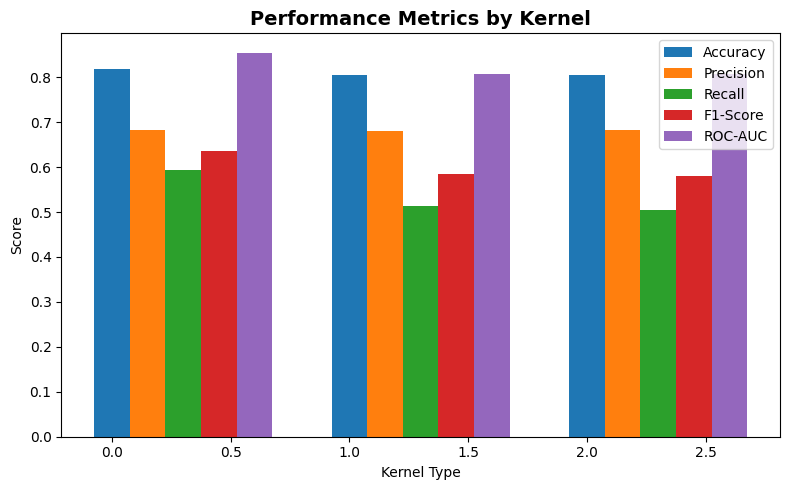

In [112]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(kernel_df))
width = 0.15

plt.figure(figsize=(8, 5))
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, kernel_df[metric], width, label=metric)

plt.xlabel('Kernel Type')
plt.ylabel('Score')
plt.title('Performance Metrics by Kernel', fontsize=14, fontweight='bold')

plt.legend()

plt.tight_layout()
plt.show()


### Tuning the C Parameter (Linear SVM)

- Tested a range of C values from 0.01 to 100 to see how the regularization affects the model performance.

#### Findings
- Validation accuracy and F1 score increased slightly as C increased.
- The best performance was at C = 100, but the performance after C = 5 was super small (not worth)
- Training and validation accuracy stayed about the same across all C values, so no major overfitting, even at high C.
- ROC–AUC values were nearly identical (0.854–0.855), so the model’s ranking ability is stable.
- Support vector counts decreased as C increased

#### Conclusion
- Higher C values reduce regularization, make the model fit the training data more closely.
- In this dataset, increasing C helps very slightly, because the data is already:
  - preety linear (tenure, charges, and contract features), it is separated after scaling.
- Improvements in precision, recall, and F1 score after C = 5 was small.
- Eventhough the best scores was at C = 100, we chose C = 5
- It achieves almost the same performance, fewer support vectors, the model slightly simpler without sacrificing much on accuracy.

In [113]:
# Test range of C values
C_values = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
C_results = []

for C in C_values:
    print(f"Testing C={C}\n")
    svm = SVC(kernel="linear", C=C, probability=True, random_state=42)
    svm.fit(x_train_scaled, y_train)

    y_val_pred = svm.predict(x_val_scaled)
    y_train_pred = svm.predict(x_train_scaled)
    y_val_proba = svm.predict_proba(x_val_scaled)[:, 1]

    result = {
        'C': C,
        'Train_Acc': accuracy_score(y_train, y_train_pred),
        'Val_Acc': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred),
        'F1-Score': f1_score(y_val, y_val_pred),
        'ROC-AUC': roc_auc_score(y_val, y_val_proba),
        'Support_Vectors': svm.n_support_.sum()
    }
    C_results.append(result)

Testing C=0.01

Testing C=0.1

Testing C=0.5

Testing C=1.0

Testing C=5.0

Testing C=10.0

Testing C=50.0

Testing C=100.0



In [114]:
C_results_df = pd.DataFrame(C_results)

print(f"C Parameter Tuning Results Liner Kernel:")
print(C_results_df.to_string(index=False))

C Parameter Tuning Results Liner Kernel:
     C  Train_Acc  Val_Acc  Precision   Recall  F1-Score  ROC-AUC  Support_Vectors
  0.01   0.799878 0.808531   0.670996 0.551601  0.605469 0.852902             2376
  0.10   0.800691 0.817062   0.681818 0.587189  0.630975 0.854732             2262
  0.50   0.802113 0.816114   0.679012 0.587189  0.629771 0.854810             2249
  1.00   0.801097 0.818009   0.681633 0.594306  0.634981 0.854824             2248
  5.00   0.801300 0.818957   0.682927 0.597865  0.637571 0.854796             2247
 10.00   0.801503 0.818009   0.681633 0.594306  0.634981 0.854856             2240
 50.00   0.800894 0.818957   0.682927 0.597865  0.637571 0.855033             2242
100.00   0.800894 0.819905   0.684211 0.601423  0.640152 0.854957             2241


In [115]:
# Todels with optimal hyperparameter

# Train optimal kNN
knn_final = KNeighborsClassifier(n_neighbors=25, metric='euclidean')
knn_final.fit(x_train_scaled, y_train)
print(f"kNN trained k=25")

# Train optimal SVM
svm_final = SVC(kernel='linear', C=5.0, probability=True, random_state=42)
svm_final.fit(x_train_scaled, y_train)
print(f"SVM trained linear kernal and c=5.0")

kNN trained k=25
SVM trained linear kernal and c=5.0


In [116]:
# Calculate all metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    return results, y_pred, y_proba

In [117]:
# Evaluate all models
models = {
    f'kNN (k=25)': knn_final,
    f'SVM (linear, C=5.0)': svm_final,
}

all_results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    results, y_pred, y_proba = evaluate_model(model, x_test_scaled, y_test, name)
    all_results.append(results)
    predictions[name] = y_pred
    probabilities[name] = y_proba

# Create DataFrame
results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))


# Save results to CSV
results_df.to_csv('knn_svm_results.csv')
print("\nResults saved to: model_results.csv")

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
         kNN (k=25)  0.781043   0.589744 0.575000  0.582278 0.813336
SVM (linear, C=5.0)  0.778199   0.599138 0.496429  0.542969 0.808371

Results saved to: model_results.csv


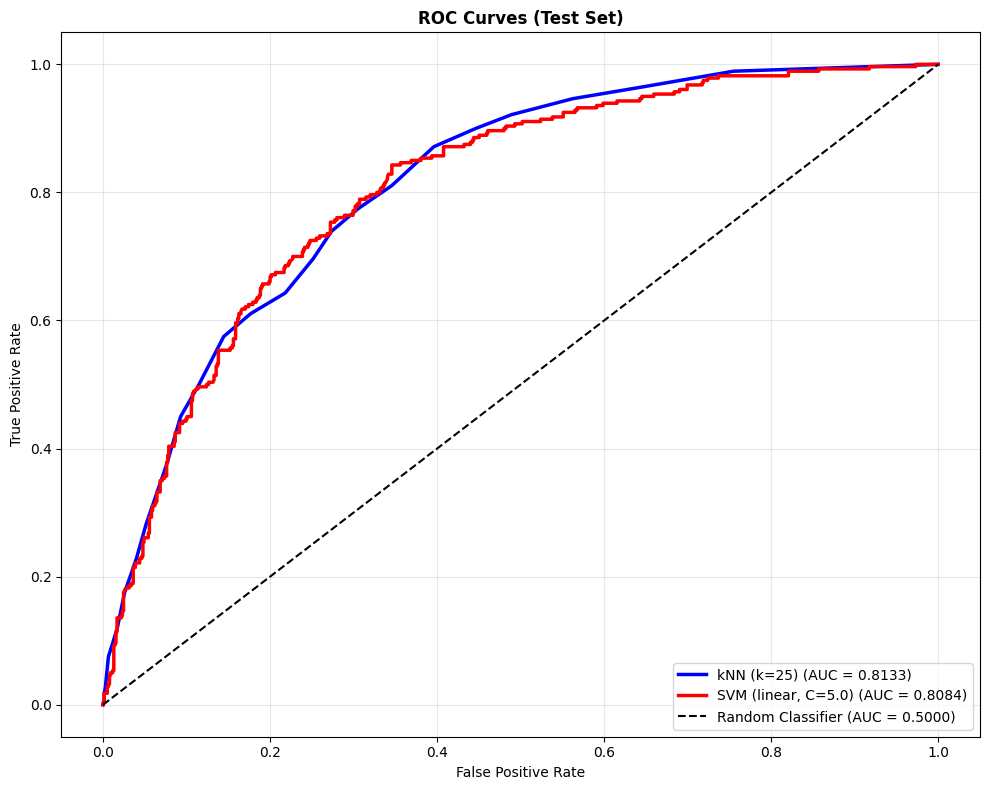

In [118]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange']
for idx, (name, y_proba) in enumerate(probabilities.items()):
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, color=colors[idx], linewidth=2.5,
                label=f'{name} (AUC = {auc:.4f})')

# Plot a random diagonal linear vlaue to see
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set)', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [119]:
# Print classification reports for main models
for name, y_pred in predictions.items():
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.85       775
       Churn       0.59      0.57      0.58       280

    accuracy                           0.78      1055
   macro avg       0.72      0.72      0.72      1055
weighted avg       0.78      0.78      0.78      1055

              precision    recall  f1-score   support

    No Churn       0.83      0.88      0.85       775
       Churn       0.60      0.50      0.54       280

    accuracy                           0.78      1055
   macro avg       0.71      0.69      0.70      1055
weighted avg       0.77      0.78      0.77      1055

